# Solving a Discretized Wave Equation in 1d with Absorbing Boundary Layers
_Disclaimer: Everything I know about PDEs and the finite difference method I learned this weekend_.

$$\varepsilon_n(i\omega - \sigma_n)^2E_n-\frac{E_{n+1}+E_{n-1}-2E_n}{\Delta x^2}-\frac{E_{n+1}-E_{n-1}}{2\Delta x}\frac{\sigma_x}{i\omega-\sigma_n}=(i\omega-\sigma_n)J_n $$

## Strategy
Combine like terms to get an equation of the form $aE_n+bE_{n+1}+cE_{n-1}=J_n$. Then create a finite-difference operator $D$ (N x N matrix) from $a$, $b$, and $c$ having the form

In [ ]:
a  b  0  0  0  0 ... 0
c  a  b  0  0  0 ... 0
0  c  a  b  0  0 ... 0
0  0                 .
.  .     .           .
.  .       .         .
.  .         .       b
0  0 ...          c  a

Next, solve for $E$ by $E=D^{-1}J$.

## Initial Attempt
Using the strategy above, I came up the the solution below. However, upon further inspection I realized a had made some incorrect assumptions and algebraic errors.

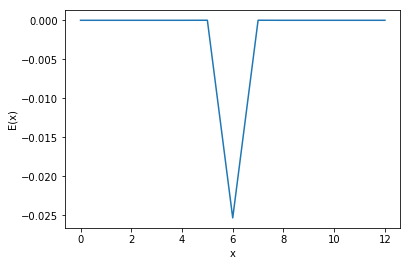

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

N = 12

def plot(e):
    plt.plot(e)
    plt.ylabel('E(x)')
    plt.xlabel('x')
    plt.show()

j = np.zeros((N + 1, 1))
j[N // 2] = 1

a = np.array([-4 * np.pi**2 + 0.02] * (N + 1))
b = np.array([-0.01] * N)

data = [a.tolist(), b.tolist(), b.tolist()]
D = diags(data, [0, 1, -1], (N + 1, N + 1))
# TODO: fix intial and final rows
D = np.matrix(D.toarray())
e = D.I * j
plot(e)

## The grid (computational cell)

In [ ]:
Left PML                                Right PML
|---|                                   |---|
J(1)=0       ...    J(60)=1       ...       J(120)=0
u=1 u=0             ...                 u=0 u=1 
|---|---|---|---|---|---|---|---|---|---|---|
x=10      ...       x=60         ...        x=120
n=1       ...       n=6          ...        n=12

The left and rightmost points represent the boundaries where $E=0$. This means the main computation will be from $n=2$ to $n=11$, i.e., throught the non-PML region. That way we will have values for $E_1$ and $E_{12}$. 

## Coefficient for $E_n$ after combining like terms
$$[\frac{(i\omega-\sigma_n)(100(i\omega-\sigma_n)^2+2)}{100(i\omega -\sigma_n)^2}]E_n$$
### When $n=1$ or $n=12$
Since $\sigma_n=12$ on the boundaries where $u=1$ and $0$ everywhere else, this becomes 
$$\frac{2+100(-12+2i\pi)^2}{100(-12+2i\pi)}$$ or $$\frac{(14402 - 4\pi^2)-4800\pi{i}}{-120+200\pi{i}}$$
### When $n=2..11$
$$2i\pi - \frac{0.01i\pi}{\pi^2}$$
## The main diagonal of D
I've probably done something wrong here because I doubt the real part of the main iterations should be 0. I assume there's some property of complex numbers I'm not aware of. 

In [13]:
En_coef_pml = np.complex(14402 - 4 * np.pi**2, -4800 * np.pi) / np.complex(-120, 200 * np.pi)
En_coef_non_pml = np.complex(0, 2 * np.pi - (0.01 * np.pi) / np.pi**2)
E_n_diag = np.empty(N, dtype=np.complex)
E_n.fill(En_coef_non_pml)
E_n_diag[0] = E_n_diag[-1] = En_coef_pml
print(E_n_diag)

[-27.3674386-17.63186729j   0.0000000 +6.28000221j   0.0000000 +6.28000221j
   0.0000000 +6.28000221j   0.0000000 +6.28000221j   0.0000000 +6.28000221j
   0.0000000 +6.28000221j   0.0000000 +6.28000221j   0.0000000 +6.28000221j
   0.0000000 +6.28000221j   0.0000000 +6.28000221j -27.3674386-17.63186729j]


## Coefficient for $E_{n+1}$ after combing like terms
I had trouble figuring out what to do with $\sigma_x$. I had three choices:
* Assume $\sigma_x=0$ because $\sigma$ only depends on $u$. I was confused by the "quadratic turn on."
* Substitute a finite-difference for $\sigma_x$.
* Treat $\sigma$ as a piecewise function where $\sigma(x)=12x^2$ at $x=1,12$ and $0$ everywhere else.

Choosing the first option gives me $$[\frac{-1}{200\pi{i}}]E_{n+1}$$, which has no real part.

Choosing the second option gives $$[\frac{-4(i\omega-\sigma_n)-\sigma_{n+1}+\sigma_{n-1}}{4\Delta{x}^2(i\omega-\sigma_n)^2}]E_{n+1}$$ and $$[\frac{-4(i\omega-\sigma_n)+\sigma_{n+1}-\sigma_{n-1}}{4\Delta{x}^2(i\omega-\sigma_n)^2}]E_{n-1}$$
### When $n=12$
$$\frac{.48-.08\pi{i}}{(144-4\pi^2)-48\pi{i}}$$
### When $n=1$ for $E_{n+1}$
$$\frac{.6-.08\pi{i}}{(144-4\pi^2)-48\pi{i}}$$
### When $n=1$ for $E_{n-1}$
$$\frac{.36-.08\pi{i}}{(144-4\pi^2)-48\pi{i}}$$
### When $n=3..10$
$$\frac{\pi{i}}{200\pi^2}$$
This is also a dead end. If I could get the coefficients for $E$, I would proceed like I did in the initial attempt to solve for and plot $E$.

$J_n=1$ at the middle of the computational cell and zero everywhere else. It would have been more convenient if $N=13$ so that there would be an exact middle. I went back and forth between $N=12$ and $N=13$. 

In [31]:
j = np.zeros(N)
j[(N - 1) / 2] = 1
print(j)

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


$\sigma_n=12$ on the boundaries where $u=1$ and $0$ everywhere else. 

In [29]:
sigma = np.zeros(N)
sigma[0] = sigma[-1] = 12
print(sigma)

[ 12.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  12.]


## Performance
Since I was unable to obtain the correct solution, I did not have an opportunity to optimize for performance. However, my general strategy would have been to ensure as many operations were vectorized as possible, keep data copying to a minimum, and then try techniques like using Cython or Numba. 

## Final Thoughts
This was a challenging exercise for me and I learned a lot about PDEs, the finite difference method, and wave equations. I would be very interested in seeing the solution. Thanks for the opportunity.